In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import xarray as xr
import pickle
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

import sys
from os.path import dirname, join, abspath

from brainmodel_utils.core.constants import RIDGECV_ALPHA_CV
from brainmodel_utils.neural_mappers import PercentileNeuralMap
from brainmodel_utils.neural_mappers.utils import (
    generate_train_test_splits,
    convert_dict_to_tuple,
)

from brainmodel_utils.metrics.consistency import get_linregress_consistency,get_linregress_consistency_persphalftrial

sys.path.insert(0, abspath(join(dirname("default_dirs.py"), '..')))
from zfa.core.default_dirs import (
    BASE_DIR,
    NEURAL_TRIALS_PATH,
    GLIAL_TRIALS_PATH,
    INTER_ANIMAL_RESULTS_DIR,
)

sys.path.insert(0, abspath(join(dirname("utils.py"), '..')))
from zfa.data_comparisons.utils import load_data_tensors



In [2]:
BASE_DIR

'/data/user_data/rdkeller/zfa/'

In [3]:
def rbf_kernel(x, x_prime, length_scale=1.0, amplitude=1.0):
    """
    Compute the RBF kernel between x and x_prime.
    """
    return amplitude**2 * np.exp(-0.5 * np.sum((x - x_prime)**2) / length_scale**2)

def compute_covariance_matrix(X, kernel_func, length_scale=1.0, amplitude=1.0):
    """
    Compute the covariance matrix for given X using specified kernel.
    """
    num_points = X.shape[0]
    K = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            K[i, j] = kernel_func(X[i], X[j], length_scale, amplitude)
    return K

def sample_gaussian_process(X, mean_values, kernel_func, num_samples=1, length_scale=1.0, amplitude=1.0):
    """
    Generate samples from a Gaussian Process with the specified mean values and kernel functions.
    """
    covariance_matrix = compute_covariance_matrix(X, kernel_func, length_scale, amplitude)

    # Ensure the covariance matrix is positive definite for Cholesky decomposition
    L = cholesky(covariance_matrix + 1e-6*np.eye(len(X)), lower=True)

    # Generate samples
    f_samples = []
    for _ in range(num_samples):
        u = np.random.normal(size=(len(X),))
        f_sample = mean_values + np.dot(L, u)
        f_samples.append(f_sample)

    return np.array(f_samples)

In [4]:
# load in targets
brain_data_tup = load_data_tensors()

 ---Loading data tensors---  


In [5]:
neural_brain_data = brain_data_tup[0]
glial_brain_data = brain_data_tup[1]
ANIMALS = list(neural_brain_data.keys())
target_animal = ANIMALS[1]
source_animal = ANIMALS[0]
#source_brain_data = glial_brain_data[source_animal]#[:,:,0:1000]
source_brain_data = glial_brain_data[target_animal]#[:,:,0:5000]

In [6]:
glial_brain_data['sub-20170228-3_ses-20170228T165730_ophys']

<xarray.DataArray (trials: 66, time: 20, units: 126467)> Size: 668MB
array([[[-1.05133057e-02,  1.44042969e-01, -1.34124756e-02, ...,
          2.57568359e-02,  5.13916016e-02,  5.21240234e-02],
        [-1.46713257e-02,  1.58813477e-01, -1.33132935e-02, ...,
          2.07824707e-02,  5.12390137e-02,  5.60302734e-02],
        [-1.05514526e-02,  1.65161133e-01, -1.39694214e-02, ...,
          1.40304565e-02,  5.64880371e-02,  5.30395508e-02],
        ...,
        [ 2.27355957e-03,  1.87500000e-01, -2.92658806e-05, ...,
          1.96533203e-02,  2.92205811e-02,  3.55224609e-02],
        [ 7.32803345e-03,  1.72973633e-01,  3.16238403e-03, ...,
          2.26440430e-02,  2.52990723e-02,  2.87933350e-02],
        [ 1.18637085e-02,  1.54541016e-01,  1.24435425e-02, ...,
          2.26745605e-02,  2.44140625e-02,  2.56805420e-02]],

       [[ 1.59263611e-03, -2.67639160e-02,  7.21359253e-03, ...,
         -9.88006592e-03, -3.28063965e-03, -3.50379944e-03],
        [-7.44342804e-04, -1.83410645e-02,  1.22909546e-02, ...,
         -5.61141968e-03,  9.36388969e-05, -6.66046143e-03],
        [-1.60026550e-03, -3.37524414e-02,  1.17416382e-02, ...,
         -5.08499146e-03, -1.22604370e-02, -9.26208496e-03],
...
          6.94274902e-04, -1.46579742e-03, -1.33037567e-03],
        [-2.36129761e-03, -7.65991211e-03,  2.07328796e-03, ...,
         -4.45556641e-03,  1.06716156e-03, -2.74467468e-03],
        [ 2.30216980e-03, -6.76345825e-03, -3.48472595e-03, ...,
         -5.61523438e-03,  1.39141083e-03,  2.21061707e-03]],

       [[-5.29766083e-04, -3.15284729e-03, -1.53064728e-03, ...,
          6.41632080e-03,  9.36126709e-03,  5.13839722e-03],
        [-1.76143646e-03,  6.58035278e-03,  1.56164169e-04, ...,
          6.16455078e-03,  9.49382782e-04,  4.45842743e-04],
        [ 8.24737549e-03,  2.53486633e-03, -9.66644287e-03, ...,
          4.21142578e-03,  5.94711304e-03,  3.19290161e-03],
        ...,
        [-8.36372375e-04, -5.87463379e-03, -4.69589233e-03, ...,
         -6.36100769e-04,  4.20761108e-03,  4.24385071e-04],
        [ 8.89301300e-04, -6.50024414e-03, -3.85665894e-03, ...,
         -2.14958191e-03, -2.99835205e-03, -2.59399414e-03],
        [-7.56835938e-03,  1.28459930e-03,  4.16564941e-03, ...,
          5.98526001e-03,  2.78663635e-03, -6.28280640e-03]]],
      dtype=float32)
Coordinates:
  * trials   (trials) int64 528B 0 1 2 3 4 5 6 7 8 ... 58 59 60 61 62 63 64 65
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 1MB 0 1 2 3 4 ... 126462 126463 126464 126465 126466

In [7]:
source_brain_data.time

<xarray.DataArray 'time' (time: 20)> Size: 160B
array([-10.      ,  -8.947368,  -7.894737,  -6.842105,  -5.789474,  -4.736842,
        -3.684211,  -2.631579,  -1.578947,  -0.526316,   0.526316,   1.578947,
         2.631579,   3.684211,   4.736842,   5.789474,   6.842105,   7.894737,
         8.947368,  10.      ])
Coordinates:
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0

In [8]:
X=np.asarray(source_brain_data.coords['time']).reshape(-1, 1)
X

array([[-10.        ],
       [ -8.94736842],
       [ -7.89473684],
       [ -6.84210526],
       [ -5.78947368],
       [ -4.73684211],
       [ -3.68421053],
       [ -2.63157895],
       [ -1.57894737],
       [ -0.52631579],
       [  0.52631579],
       [  1.57894737],
       [  2.63157895],
       [  3.68421053],
       [  4.73684211],
       [  5.78947368],
       [  6.84210526],
       [  7.89473684],
       [  8.94736842],
       [ 10.        ]])

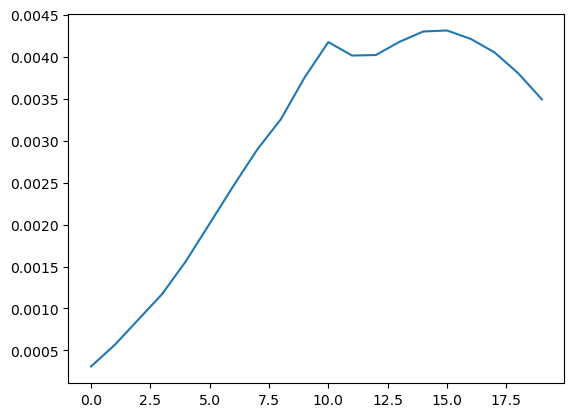

In [9]:
mean_time_series = np.asarray(source_brain_data.mean(dim = 'trials').mean(dim = 'units'))
plt.plot(mean_time_series)

In [10]:
samples = sample_gaussian_process(X, mean_time_series, rbf_kernel, num_samples=len(source_brain_data.coords['units']),length_scale = 1.0,amplitude=1e-3)


In [11]:
samples.T.shape

(20, 122296)

In [12]:
#generate gaussian process around source mean response

X = np.asarray(source_brain_data.coords['time']).reshape(-1, 1)

#X = np.linspace(0, 10, 200).reshape(-1, 1)
mean_time_series = np.asarray(source_brain_data.mean(dim = 'trials').mean(dim = 'units'))
samples = sample_gaussian_process(X, mean_time_series, rbf_kernel, num_samples=len(source_brain_data.coords['units']),length_scale = 1.0,amplitude=1e-3)

coords_sample_source = {
    "time": source_brain_data.coords['time'],    # replace with your actual coordinates
    "units": source_brain_data.coords['units']   # replace with your actual coordinates
}


sample_source_x_arr = xr.DataArray(samples.T, dims=("time", "units"), coords = coords_sample_source)


In [13]:
coords_sample_source

{'time': <xarray.DataArray 'time' (time: 20)> Size: 160B
 array([-10.      ,  -8.947368,  -7.894737,  -6.842105,  -5.789474,  -4.736842,
         -3.684211,  -2.631579,  -1.578947,  -0.526316,   0.526316,   1.578947,
          2.631579,   3.684211,   4.736842,   5.789474,   6.842105,   7.894737,
          8.947368,  10.      ])
 Coordinates:
   * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0,
 'units': <xarray.DataArray 'units' (units: 122296)> Size: 978kB
 array([     0,      1,      2, ..., 122293, 122294, 122295])
 Coordinates:
   * units    (units) int64 978kB 0 1 2 3 4 ... 122292 122293 122294 122295}

In [14]:
# for sample in samples:
#     plt.plot(X, sample,alpha = 0.1,color = 'g',linewidth = 1)
# plt.plot(X,mean_time_series,color = 'k',linewidth = 2)

In [15]:
# save data and check if loading works

def pickle_load(file_path):
    with open(file_path, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [16]:
# #save the data
# with open(BASE_DIR + 'gp1.pickle', 'wb') as handle:
#     pickle.dump(sample_source_x_arr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
gp_data = pickle_load(BASE_DIR + 'gp1.pickle')
gp_data

<xarray.DataArray (time: 20, units: 122296)> Size: 20MB
array([[ 0.00199169,  0.00157667, -0.0008888 , ..., -0.00220141,
         0.00072706, -0.00029142],
       [ 0.00086012,  0.00212136, -0.00055693, ...,  0.00043416,
         0.00115465,  0.00018243],
       [ 0.00088764,  0.00027756,  0.00157073, ...,  0.00060824,
        -0.00046827, -0.00013917],
       ...,
       [ 0.00431579,  0.00364748,  0.00469642, ...,  0.00394568,
         0.00548368,  0.00456302],
       [ 0.0045541 ,  0.00178465,  0.00213925, ...,  0.00139016,
         0.00515835,  0.00335291],
       [ 0.00367909,  0.00284951,  0.00456094, ...,  0.002192  ,
         0.00474154,  0.0036149 ]])
Coordinates:
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 978kB 0 1 2 3 4 ... 122292 122293 122294 122295

In [18]:
white_noise = np.random.normal(0,1,size = (len(source_brain_data.coords['time']), len(source_brain_data['units'])))
coords_sample_source = {
    "time": source_brain_data.coords['time'],    # replace with your actual coordinates
    "units": source_brain_data.coords['units']   # replace with your actual coordinates
}

white_noise_xarr = xr.DataArray(white_noise, dims=("time", "units"), coords = coords_sample_source)
white_noise_xarr

<xarray.DataArray (time: 20, units: 122296)> Size: 20MB
array([[ 0.55251256, -0.34750137, -0.77716099, ..., -0.90572311,
         1.41614706,  1.24526828],
       [-0.95156409,  0.57812299, -1.23459707, ..., -0.43094751,
         0.18014002, -0.68365335],
       [-2.44480147,  0.46127164,  1.01837169, ...,  1.68110824,
         1.18048501, -0.70351725],
       ...,
       [-0.1075204 , -0.08633193, -1.1000981 , ..., -0.72024017,
         0.08832976,  1.57578439],
       [ 0.68603569,  0.62777769, -0.73151721, ...,  0.43322428,
         0.25844078,  1.06377602],
       [ 0.28550772, -0.58727593, -0.51930714, ..., -2.73959444,
         0.77236948, -0.80012747]])
Coordinates:
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 978kB 0 1 2 3 4 ... 122292 122293 122294 122295

In [19]:
#  #save the data
# with open(BASE_DIR + 'white_noise.pickle', 'wb') as handle:
#     pickle.dump(white_noise_xarr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
white_noise_data = pickle_load(BASE_DIR + 'white_noise.pickle')
white_noise_data

<xarray.DataArray (time: 20, units: 122296)> Size: 20MB
array([[ 1.27094461,  0.5219656 , -0.95567861, ...,  0.15740957,
        -0.43581435, -0.10805487],
       [-1.19542242,  0.15131232, -0.74353758, ..., -0.7957122 ,
         0.31616021,  0.18630719],
       [ 0.13914078,  0.59334137,  0.32254494, ...,  0.45731064,
         0.08287829,  0.40918777],
       ...,
       [-0.68216905, -1.64193163, -0.75043327, ...,  1.55953034,
         0.21786815, -0.1572423 ],
       [ 1.89605785,  0.07062139, -1.53003001, ...,  1.03982963,
         0.93034978, -0.18140592],
       [ 0.72847755,  0.32695412, -1.22188213, ...,  0.99924099,
         1.59565545, -1.42899853]])
Coordinates:
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 978kB 0 1 2 3 4 ... 122292 122293 122294 122295

In [21]:
#generate gaussian process around source mean response

X = np.asarray(source_brain_data.coords['time']).reshape(-1, 1)

#X = np.linspace(0, 10, 200).reshape(-1, 1)
mean_time_series = np.asarray(source_brain_data.mean(dim = 'trials').mean(dim = 'units'))
samples = sample_gaussian_process(X, mean_time_series, rbf_kernel, num_samples=len(source_brain_data.coords['units']),length_scale = 1.0,amplitude=1e-3)

coords_sample_source = {
    "time": source_brain_data.coords['time'],    # replace with your actual coordinates
    "units": source_brain_data.coords['units']   # replace with your actual coordinates
}


sample_source_x_arr = xr.DataArray(samples.T, dims=("time", "units"), coords = coords_sample_source)


In [22]:
mts_reshape = mean_time_series[np.newaxis, :]
mts_reshape.shape

(1, 20)

In [23]:
coords_sample_source = {
    "time": source_brain_data.coords['time'],    # replace with your actual coordinates
    "units": source_brain_data.coords['units'][:1]   # replace with your actual coordinates
}


mean_time_series_xarr = xr.DataArray(mts_reshape.T,  dims=("time", "units"), coords=coords_sample_source)
mean_time_series_xarr

<xarray.DataArray (time: 20, units: 1)> Size: 80B
array([[0.00030871],
       [0.00056587],
       [0.00086947],
       [0.00117299],
       [0.00156434],
       [0.0020117 ],
       [0.00246089],
       [0.00289249],
       [0.00325541],
       [0.00375257],
       [0.00417452],
       [0.00401413],
       [0.00402016],
       [0.00417796],
       [0.00430092],
       [0.0043129 ],
       [0.00421237],
       [0.00405264],
       [0.00380308],
       [0.00349163]], dtype=float32)
Coordinates:
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 8B 0

In [24]:
# #save the data
# with open(BASE_DIR + 'avg1.pickle', 'wb') as handle:
#     pickle.dump(mean_time_series_xarr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
avg0_data = pickle_load(BASE_DIR + 'avg1.pickle')
avg0_data

<xarray.DataArray (time: 20, units: 1)> Size: 80B
array([[0.00030871],
       [0.00056587],
       [0.00086947],
       [0.00117299],
       [0.00156434],
       [0.0020117 ],
       [0.00246089],
       [0.00289249],
       [0.00325541],
       [0.00375257],
       [0.00417452],
       [0.00401413],
       [0.00402016],
       [0.00417796],
       [0.00430092],
       [0.0043129 ],
       [0.00421237],
       [0.00405264],
       [0.00380308],
       [0.00349163]], dtype=float32)
Coordinates:
  * time     (time) float64 160B -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 8B 0